In [3]:
!pip install browser_history


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [226]:
from browser_history.browsers import Chrome
import csv
import matplotlib.pyplot as plt

chrome = Chrome()
history = chrome.fetch_history()

with open('chrome_browser_history.csv', mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    
    for entry in history.histories:
        writer.writerow(entry)

print("Browser history saved to 'chrome_browser_history.csv'.")

Browser history saved to 'chrome_browser_history.csv'.


In [44]:
import pandas as pd

In [46]:
df = pd.read_csv('chrome_browser_history.csv', header=None, names=['Time','Site','Title'])

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30817 entries, 0 to 30816
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Time    30817 non-null  object
 1   Site    30817 non-null  object
 2   Title   30556 non-null  object
dtypes: object(3)
memory usage: 722.4+ KB


In [34]:
df.shape

(30818, 3)

In [212]:
df.head()

,Time,domain
0,2024-11-14 19:50:11-05:00,www.instagram.com
1,2024-11-14 19:50:13-05:00,www.instagram.com
2,2024-11-14 19:50:17-05:00,www.instagram.com
3,2024-11-14 19:50:20-05:00,www.instagram.com
4,2024-11-14 19:50:29-05:00,www.instagram.com


In [211]:
df.tail()

,Time,domain
30812,2025-02-12 18:58:10-05:00,colab.research.google.com
30813,2025-02-12 19:01:56-05:00,search.yahoo.com
30814,2025-02-12 19:15:23-05:00,chatgpt.com
30815,2025-02-12 19:15:25-05:00,chatgpt.com
30816,2025-02-12 19:15:26-05:00,chatgpt.com


In [49]:
df.isna().sum()

Time       0
Site       0
Title    261
dtype: int64

In [50]:
from urllib.parse import urlparse

def get_domain(url):
    domain = urlparse(url).netloc
    
    if domain == '':
        return None

    return domain

In [51]:
df['domain'] = [ get_domain(s)  for s in df['Site'] ]

In [52]:
df.drop('Site', axis=1, inplace=True) # drop Site column & update the current df object
df.drop('Title', axis=1, inplace=True) 

In [58]:
df.isna().sum()

Time      0
domain    0
dtype: int64

In [238]:
df.dropna(inplace=True)

C:\Users\nhobl\AppData\Local\Temp\ipykernel_29716\2952506657.py:8: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['Month'] = df['Time'].dt.to_period('M')


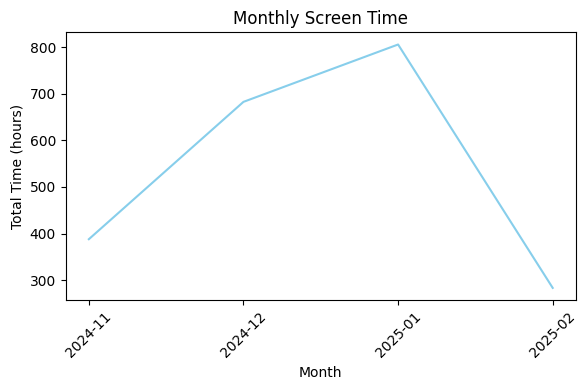

In [255]:
df['Time'] = pd.to_datetime(df['Time'])
df = df.sort_values(by='Time')

df['Duration'] = df['Time'].diff().fillna(pd.Timedelta(seconds=0))

df['Duration'] = df['Duration'].dt.total_seconds() / 3600  

df['Month'] = df['Time'].dt.to_period('M')

time_spent_month = df.groupby('Month')['Duration'].sum().reset_index()

plt.figure(figsize=(6, 4))
plt.plot(time_spent_month['Month'].astype(str), time_spent_month['Duration'], color='skyblue')

plt.title('Monthly Screen Time')
plt.xlabel('Month')
plt.ylabel('Total Time (hours)') 
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

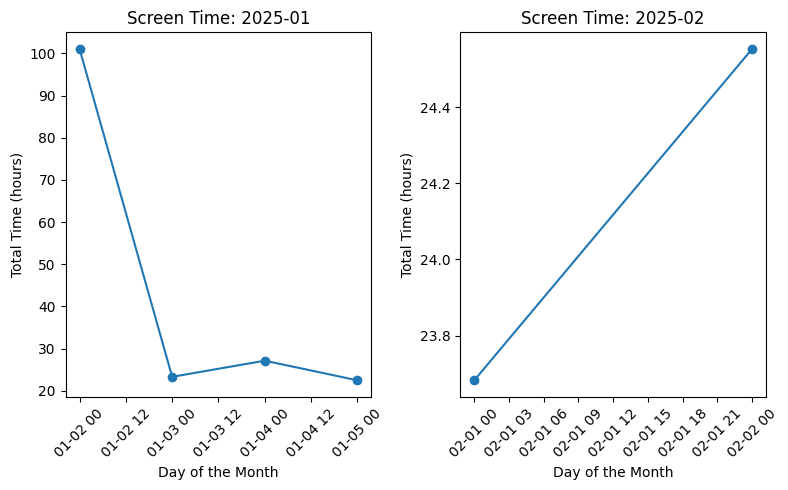

In [252]:

df['Year'] = df['Time'].dt.year
df['Month'] = df['Time'].dt.month
df['Day'] = df['Time'].dt.date
df['Week_of_month'] = df['Time'].dt.isocalendar().week - df['Time'].dt.month.apply(lambda x: (x - 1) * 4)

first_week_df = df[df['Week_of_month'] == 1]

time_spent_first_week = first_week_df.groupby(['Year', 'Month', 'Day'])['Duration'].sum().reset_index()

unique_year_months = time_spent_first_week[['Year', 'Month']].drop_duplicates()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))

axes = axes.flatten()

for i, (year, month) in enumerate(unique_year_months.head(2).values):
    data = time_spent_first_week[(time_spent_first_week['Year'] == year) & (time_spent_first_week['Month'] == month)]
    axes[i].plot(data['Day'], data['Duration'], marker='o')
    axes[i].set_title(f'Screen Time: {year}-{month:02d}')
    axes[i].set_xlabel('Day of the Month')
    axes[i].set_ylabel('Total Time (hours)')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


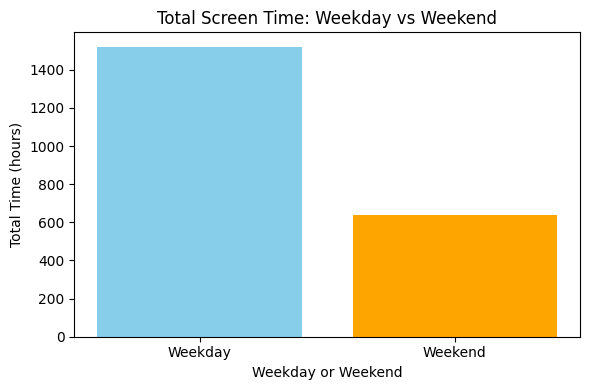

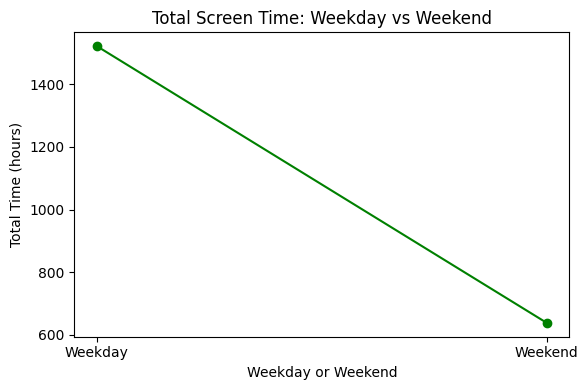

In [261]:

df['Day_of_week'] = df['Time'].dt.dayofweek

df['Weekday_or_Weekend'] = df['Day_of_week'].apply(lambda x: 'Weekday' if x < 5 else 'Weekend')

time_spent_weekday_weekend = df.groupby('Weekday_or_Weekend')['Duration'].sum().reset_index()


plt.figure(figsize=(6, 4))
plt.bar(time_spent_weekday_weekend['Weekday_or_Weekend'], time_spent_weekday_weekend['Duration'], color=['skyblue', 'orange'])

plt.title('Total Screen Time: Weekday vs Weekend')
plt.xlabel('Weekday or Weekend')
plt.ylabel('Total Time (hours)')
plt.tight_layout()
plt.show()

# Plot Line Graph
plt.figure(figsize=(6, 4))
plt.plot(time_spent_weekday_weekend['Weekday_or_Weekend'], time_spent_weekday_weekend['Duration'], marker='o', color='green')

plt.title('Total Screen Time: Weekday vs Weekend')
plt.xlabel('Weekday or Weekend')
plt.ylabel('Total Time (hours)')
plt.tight_layout()
plt.show()


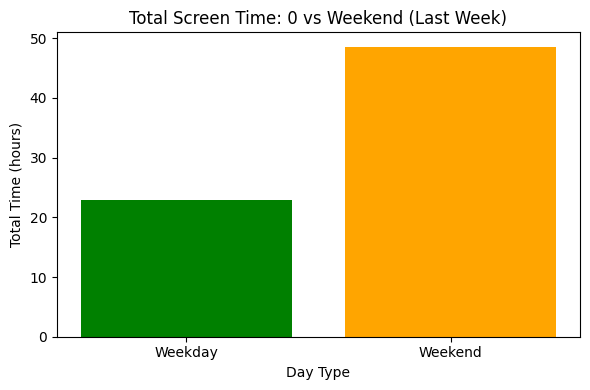

In [270]:
last_week_data = df[df['Time'] >= df['Time'].max() - pd.Timedelta(weeks=1)]

specific_weekday = 0 
weekday_data = last_week_data[last_week_data['Time'].dt.dayofweek == specific_weekday]

weekend_data = last_week_data[last_week_data['Time'].dt.dayofweek.isin([5, 6])]

total_weekday_time = weekday_data['Duration'].sum()
total_weekend_time = weekend_data['Duration'].sum()

time_comparison = pd.DataFrame({
    'Day Type': ['Weekday', 'Weekend'],
    'Total Hours': [total_weekday_time, total_weekend_time]
})


plt.figure(figsize=(6, 4))
plt.bar(time_comparison['Day Type'], time_comparison['Total Hours'], color=['green', 'orange'])

plt.title(f"Total Screen Time: {specific_weekday} vs Weekend (Last Week)")
plt.xlabel('Day Type')
plt.ylabel('Total Time (hours)')
plt.tight_layout()
plt.show()


C:\Users\nhobl\AppData\Local\Temp\ipykernel_29716\994334793.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['Week'] = df['Time'].dt.to_period('W')


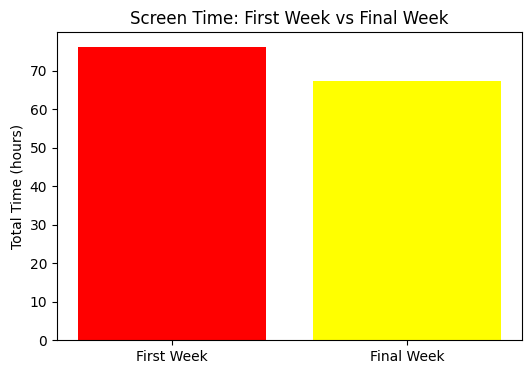

In [269]:

df['Week'] = df['Time'].dt.to_period('W')

time_spent_week = df.groupby('Week')['Duration'].sum().reset_index()

start_week = time_spent_week.iloc[0]
last_week = time_spent_week.iloc[-1]

plt.figure(figsize=(6, 4))
weeks = ['First Week', 'Final Week']
time_spent = [start_week['Duration'], last_week['Duration']]

plt.bar(weeks, time_spent, color=['red', 'yellow'])
plt.title('Screen Time: First Week vs Final Week')
plt.ylabel('Total Time (hours)')
plt.show()


C:\Users\nhobl\AppData\Local\Temp\ipykernel_29716\4185192072.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weekday_data['Hour'] = weekday_data['Time'].dt.hour
C:\Users\nhobl\AppData\Local\Temp\ipykernel_29716\4185192072.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weekend_data['Hour'] = weekend_data['Time'].dt.hour


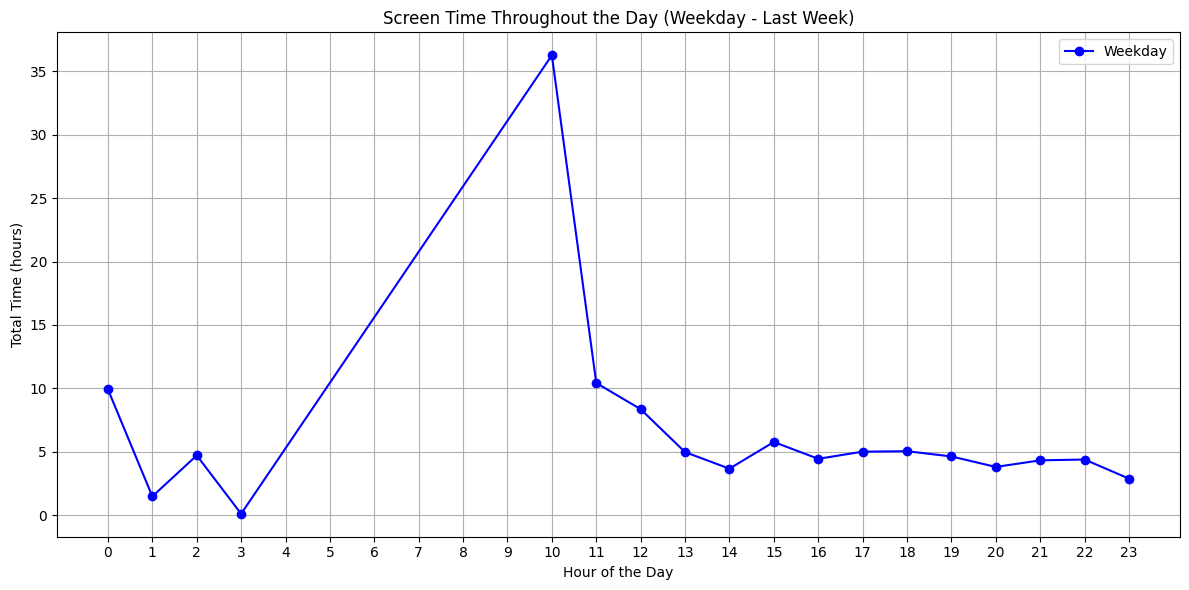

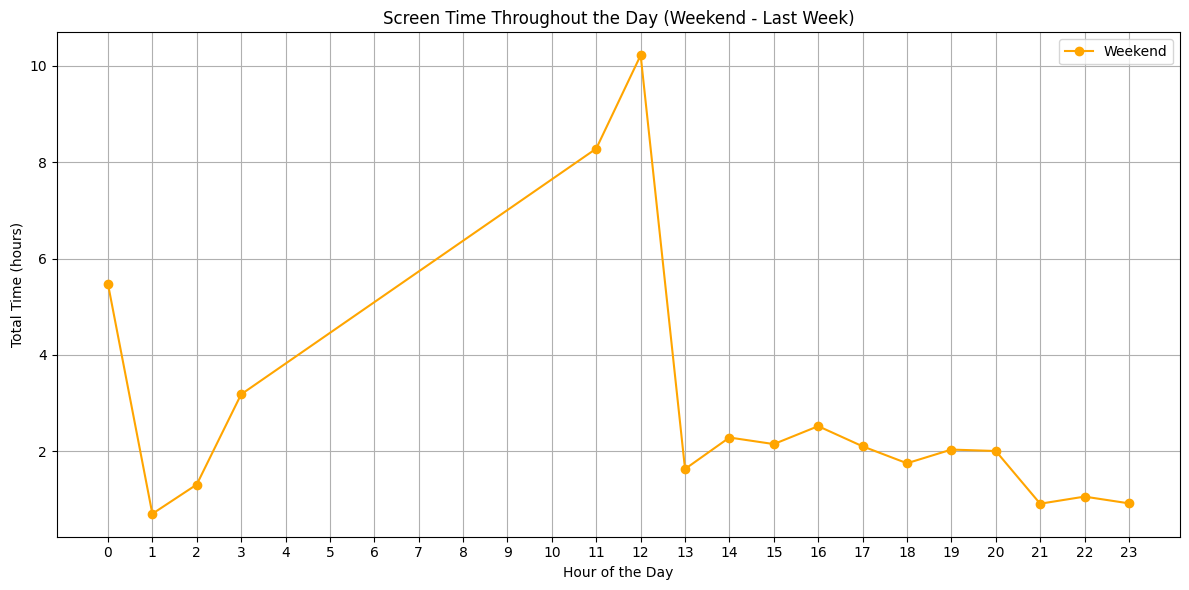

In [271]:
last_week_data = df[df['Time'] >= df['Time'].max() - pd.Timedelta(weeks=1)]
weekday_data = last_week_data[last_week_data['Time'].dt.dayofweek < 5]  
weekend_data = last_week_data[last_week_data['Time'].dt.dayofweek >= 5]  

weekday_data['Hour'] = weekday_data['Time'].dt.hour
weekend_data['Hour'] = weekend_data['Time'].dt.hour

weekday_screen_time = weekday_data.groupby('Hour')['Duration'].sum().reset_index()
weekend_screen_time = weekend_data.groupby('Hour')['Duration'].sum().reset_index()


plt.figure(figsize=(12, 6))
plt.plot(weekday_screen_time['Hour'], weekday_screen_time['Duration'], marker='o', color='blue', label='Weekday')
plt.title('Screen Time Throughout the Day (Weekday - Last Week)')
plt.xlabel('Hour of the Day')
plt.ylabel('Total Time (hours)')
plt.xticks(range(24))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 6))
plt.plot(weekend_screen_time['Hour'], weekend_screen_time['Duration'], marker='o', color='orange', label='Weekend')
plt.title('Screen Time Throughout the Day (Weekend - Last Week)')
plt.xlabel('Hour of the Day')
plt.ylabel('Total Time (hours)')
plt.xticks(range(24))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [62]:
def check(x):
    return True

df_clean = df[[ check(x) for x in df.domain]]
df_clean

,Time,domain
0,2024-11-14 19:50:11-05:00,www.instagram.com
1,2024-11-14 19:50:13-05:00,www.instagram.com
2,2024-11-14 19:50:17-05:00,www.instagram.com
3,2024-11-14 19:50:20-05:00,www.instagram.com
4,2024-11-14 19:50:29-05:00,www.instagram.com
...,...,...
30812,2025-02-12 18:58:10-05:00,colab.research.google.com
30813,2025-02-12 19:01:56-05:00,search.yahoo.com
30814,2025-02-12 19:15:23-05:00,chatgpt.com
30815,2025-02-12 19:15:25-05:00,chatgpt.com


In [136]:
df_clean.to_csv('history_cleaned.csv', index=False)

In [137]:
new_df = pd.read_csv('history_cleaned.csv')

In [139]:
new_df.tail()

,Time,domain
30793,2025-02-12 18:58:10-05:00,colab.research.google.com
30794,2025-02-12 19:01:56-05:00,search.yahoo.com
30795,2025-02-12 19:15:23-05:00,chatgpt.com
30796,2025-02-12 19:15:25-05:00,chatgpt.com
30797,2025-02-12 19:15:26-05:00,chatgpt.com


In [141]:
new_df.describe()

,Time,domain
count,30798,30798
unique,26812,562
top,2025-02-05 10:35:17-05:00,www.instagram.com
freq,20,8628


In [142]:
grp_df = new_df.groupby('domain').agg({'domain' : 'count'}).rename(columns={'domain':"No of visits"}).reset_index()

In [143]:
grp_df = grp_df.sort_values(by='No of visits', ascending=False)

In [144]:
grp_df.head(15)

,domain,No of visits
434,www.instagram.com,8628
61,colab.research.google.com,2428
34,blackboard.umbc.edu,1667
162,mail.google.com,1527
371,www.chess.com,1329
422,www.google.com,1118
306,webauth.umbc.edu,1021
345,www.amazon.com,916
380,www.coursera.org,910
556,www.youtube.com,735


In [208]:
new_df['Time']= pd.to_datetime(new_df['Time'])

In [207]:
new_df['Month-Year'] = new_df['Time'].dt.to_period('M')
monthly_visits = new_df.groupby(['domain', 'Month-Year']).size().reset_index(name='No of visits')

C:\Users\nhobl\AppData\Local\Temp\ipykernel_29716\2756302778.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  new_df['Month-Year'] = new_df['Time'].dt.to_period('M')


In [209]:
monthly_visits.columns

Index(['domain', 'Month-Year', 'No of visits'], dtype='object')

In [175]:
top_10_domains = monthly_visits.groupby('domain')['No of visits'].sum().nlargest(10).index
monthly_visits_top_10 = monthly_visits[monthly_visits['domain'].isin(top_10_domains)]
month_on_month_pivot = monthly_visits_top_10.pivot(index='domain', columns='Month-Year', values='No of visits').fillna(0)
month_on_month_pivot = month_on_month_pivot.reset_index()
print(month_on_month_pivot)

Month-Year                     domain  2024-11  2024-12  2025-01  2025-02
0                 blackboard.umbc.edu    418.0    817.0    159.0    273.0
1           colab.research.google.com      0.0    777.0      1.0   1650.0
2                     mail.google.com    354.0    371.0    503.0    299.0
3                    webauth.umbc.edu    216.0    310.0    270.0    225.0
4                      www.amazon.com     89.0    706.0     20.0    101.0
5                       www.chess.com     54.0     89.0    166.0   1020.0
6                    www.coursera.org      0.0      0.0    106.0    804.0
7                      www.google.com     16.0   1058.0     22.0     22.0
8                   www.instagram.com   1565.0   2970.0    121.0   3972.0
9                     www.youtube.com      9.0    238.0    421.0     67.0


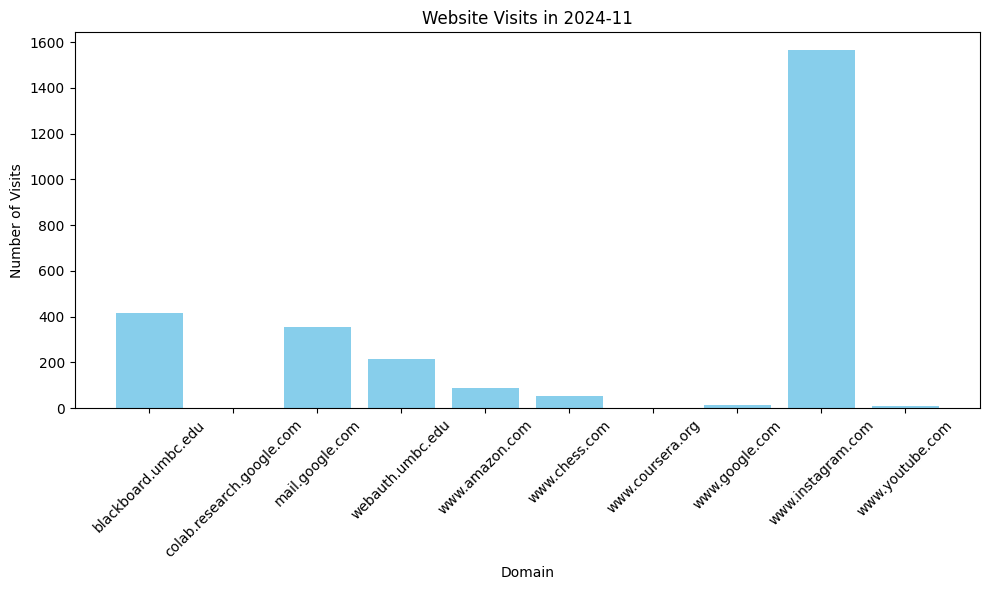

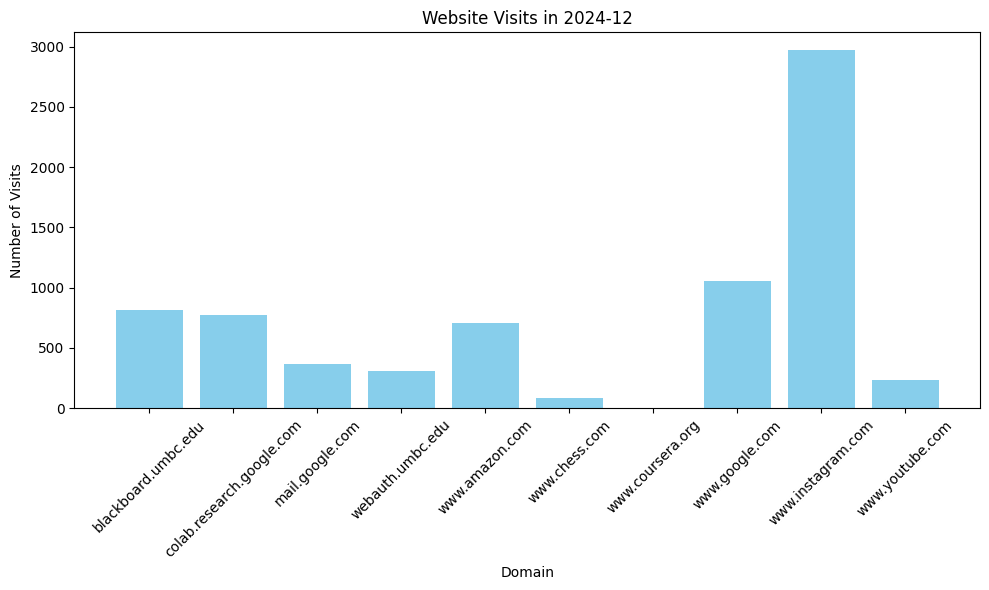

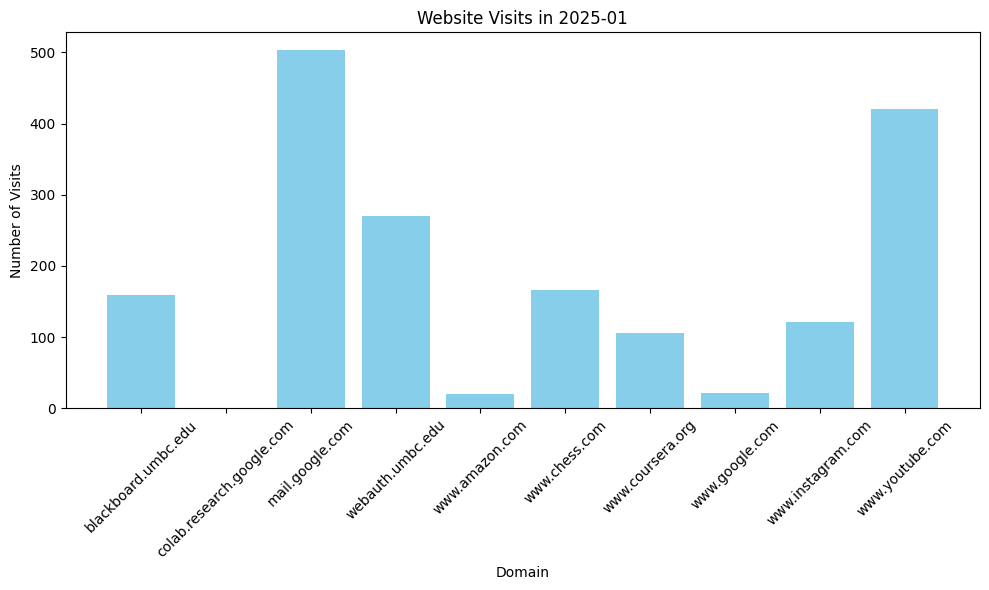

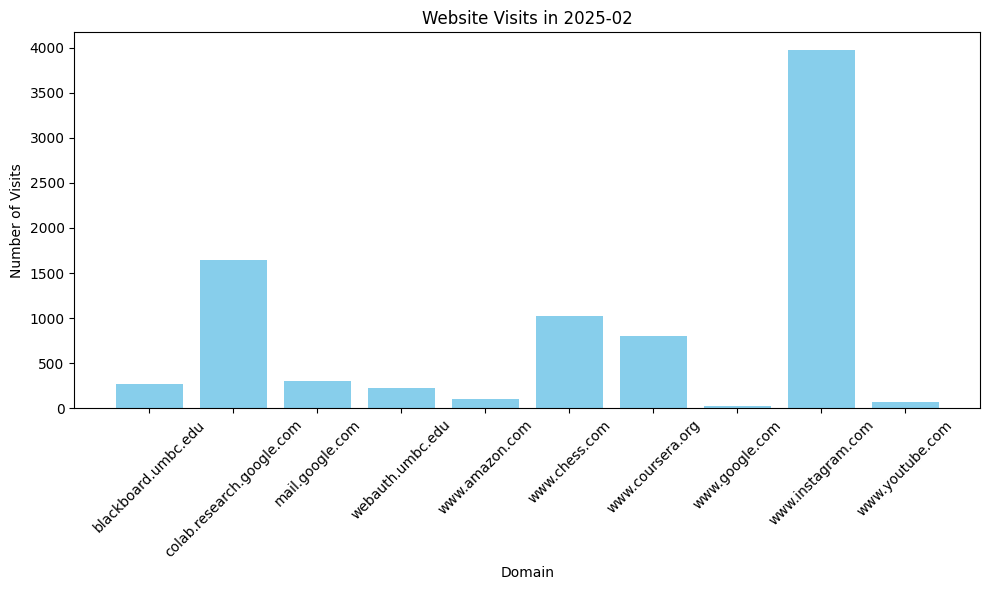

In [210]:
import matplotlib.pyplot as plt
import pandas as pd

month_on_month_pivot.set_index('domain', inplace=True)

for month in month_on_month_pivot.columns:
    plt.figure(figsize=(10, 6))
    plt.bar(month_on_month_pivot.index, month_on_month_pivot[month].values, color='skyblue') 
    plt.title(f'Website Visits in {month}')
    plt.xlabel('Domain')
    plt.ylabel('Number of Visits')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

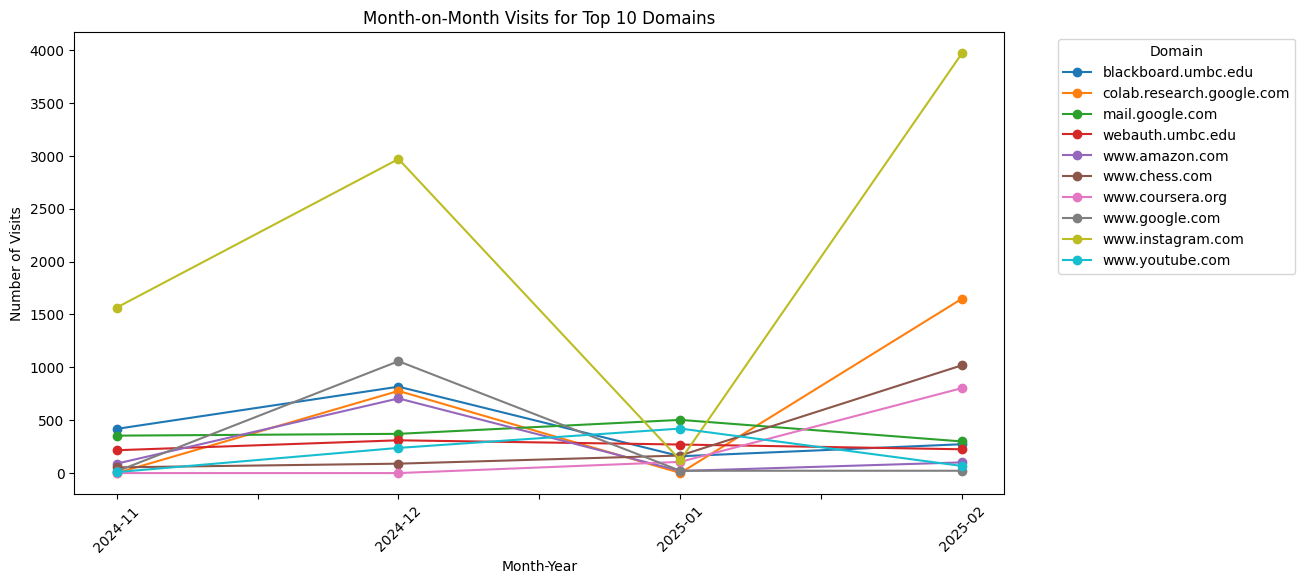

In [156]:
import matplotlib.pyplot as plt

month_on_month_pivot.set_index('domain').T.plot(figsize=(12, 6), marker='o')

plt.xlabel("Month-Year")
plt.ylabel("Number of Visits")
plt.title("Month-on-Month Visits for Top 10 Domains")
plt.legend(title="Domain", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)  
plt.show()


In [ ]:
Is this a work computer/personal computer?
Personal computer

In [ ]:
Is user employed?
Maybe not, because we can see the screen time starts somewhere after 11 pm and ends around 3 am so may not be employed or might be working remotely as well 



In [ ]:
What else can we say about this person?
The duration of screen time has reduced recently that is from january

In [ ]:
What are the person's interests?
Instagram, chess, colab

In [ ]:
Anything interesting?
The trends in instagram maybe trying to reduce it 

In [ ]:
What else can we tell about this person?
Studying or researching a lot lately, definetly likes playing chess and spending time on instagram